In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mtsamplesdataset/mtsamples.csv
/kaggle/input/glove-weights-for-nlp/glove.6B.100d.txt


In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings (if using TF)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Specify GPU if needed

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
import os
os.listdir("/kaggle/input/mtsamplesdataset")

['mtsamples.csv']

In [6]:
data = pd.read_csv("/kaggle/input/mtsamplesdataset/mtsamples.csv")

In [7]:
data.columns

Index(['description', 'medical_specialty', 'sample_name', 'transcription',
       'keywords'],
      dtype='object')

In [8]:
data = data[['transcription', 'medical_specialty','keywords']]
print(len(data[data['transcription'].isna()]))
print("Before dropping na values", data.shape)
data = data.drop(data[data['transcription'].isna()].index)
print("After dropping na values", data.shape)

33
Before dropping na values (4999, 3)
After dropping na values (4966, 3)


In [9]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Ensure you have the necessary resources
nltk.download('punkt_tab')
nltk.download('stopwords')

# Function for text cleaning & normalization
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
        text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    return text

# Apply cleaning to transcription column
data["transcription"] = data["transcription"].apply(clean_text)

data['keywords'] = data['keywords'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x)))

# Load stopwords
stop_words = set(stopwords.words("english"))

# Function to remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

# Apply stopword removal
data["transcription"] = data["transcription"].apply(remove_stopwords)

data.to_csv("/kaggle/working/mtsamples_cleaned.csv", index=False)

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Tokenize only (no stopword removal)
def tokenize_text(text):
    return word_tokenize(text)

# Apply to your 'transcription' column
data["tokens"] = data["transcription"].apply(tokenize_text)
print(data["tokens"].head())

0    [subjective, yearold, white, female, presents,...
1    [past, medical, history, difficulty, climbing,...
2    [history, present, illness, seen, abc, today, ...
3    [mmode, left, atrial, enlargement, left, atria...
4    [left, ventricular, cavity, size, wall, thickn...
Name: tokens, dtype: object


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
le = LabelEncoder()
data['label'] = le.fit_transform(data['medical_specialty'])

# Split dataset (80-20) stratified by label
X_train, X_test, y_train, y_test = train_test_split(
    data['transcription'], data['label'],
    test_size=0.2,
    stratify=data['label'],
    random_state=42
)

# Display a few entries
print(X_train.head(), y_train.head())

2273    preoperative diagnosis closed displaced probab...
1405    chief complaint stage iiic endometrial cancer ...
4816    endovascular brachytherapy ebtthe patient unde...
4329    subjective yearold white male established pati...
3348    chief complaint mental changes todayhistory pr...
Name: transcription, dtype: object 2273    27
1405    35
4816     3
4329     5
3348    15
Name: label, dtype: int64


In [13]:
!pip install nlpaug
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 1.8 MB/s eta 0:00:0000:0100:01m


In [14]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='nltk')

In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nlpaug.augmenter.word as naw
import nltk
from collections import Counter

# Assuming you have a DataFrame 'data' with columns 'transcription' (medical transcriptions) and 'medical_specialty' (clinical domain)
# If not, adapt the code to your actual data structure

# Download necessary NLTK resources for NLP Augmenter
nltk.download('wordnet')
nltk.download('omw-1.4')

# Display initial class distribution
print("Original class distribution:")
print(data['medical_specialty'].value_counts())

# 1. NLP Augmenter Method
def balance_with_nlp_augmenter(data, target_samples_per_class=1500):
    """
    Balance dataset using NLP Augmenter by replacing words with synonyms.
    
    Args:
        data: DataFrame with 'transcription' and 'medical_specialty' columns
        target_samples_per_class: Number of samples to generate for each class
    
    Returns:
        Balanced DataFrame
    """
    # Initialize synonym augmenter
    aug = naw.SynonymAug(aug_src='wordnet')
    
    balanced_texts = []
    balanced_categories = []
    
    # Process each medical specialty
    for specialty in data['medical_specialty'].unique():
        # Get samples of the current specialty
        specialty_samples = data[data['medical_specialty'] == specialty]
        
        # Add original samples
        balanced_texts.extend(specialty_samples['transcription'].tolist())
        balanced_categories.extend([specialty] * len(specialty_samples))
        
        # Calculate how many additional samples we need
        n_to_add = max(0, target_samples_per_class - len(specialty_samples))
        
        # If we need to add samples
        if n_to_add > 0:
            # Augment samples until we reach target
            samples_to_augment = specialty_samples['transcription'].tolist()
            augmented_counter = 0
            
            while augmented_counter < n_to_add:
                # Cycle through available samples
                for text in samples_to_augment:
                    if augmented_counter >= n_to_add:
                        break
                    
                    # Create augmented text
                    augmented_text = aug.augment(text)
                    balanced_texts.append(augmented_text)
                    balanced_categories.append(specialty)
                    augmented_counter += 1
    
    # Create balanced DataFrame
    balanced_data = pd.DataFrame({
        'transcription': balanced_texts,
        'medical_specialty': balanced_categories
    })
    
    return balanced_data

E0000 00:00:1746467955.244538      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746467955.305618      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Original class distribution:
medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Psychiatry / Psychology            53
Office Notes                       50
Podiatry                           47
Dermatology                        29
Dentistry                          27
Cos

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [17]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron

True

In [18]:
# Apply the balancing function
balanced_data = balance_with_nlp_augmenter(data, target_samples_per_class=1500)

# Display new class distribution
print("\nBalanced class distribution:")
print(balanced_data['medical_specialty'].value_counts())


Balanced class distribution:
medical_specialty
Allergy / Immunology             1500
Bariatrics                       1500
Cardiovascular / Pulmonary       1500
Neurology                        1500
Dentistry                        1500
Urology                          1500
General Medicine                 1500
Surgery                          1500
Speech - Language                1500
SOAP / Chart / Progress Notes    1500
Sleep Medicine                   1500
Rheumatology                     1500
Radiology                        1500
Psychiatry / Psychology          1500
Podiatry                         1500
Physical Medicine - Rehab        1500
Pediatrics - Neonatal            1500
Pain Management                  1500
Orthopedic                       1500
Ophthalmology                    1500
Office Notes                     1500
Obstetrics / Gynecology          1500
Neurosurgery                     1500
Nephrology                       1500
Letters                          1500
La

In [19]:
# Ensure all transcriptions are strings, even if they are returned as lists from augmentation
def ensure_string(x):
    if isinstance(x, list):
        return ' '.join(x)
    return str(x)

# Apply to the transcription column
balanced_data['transcription'] = balanced_data['transcription'].apply(ensure_string)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Split data
X = balanced_data['transcription']
y = balanced_data['medical_specialty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Naive Bayes Accuracy: 0.7639
Precision: 0.7440
Recall: 0.7639
F1 Score: 0.7479


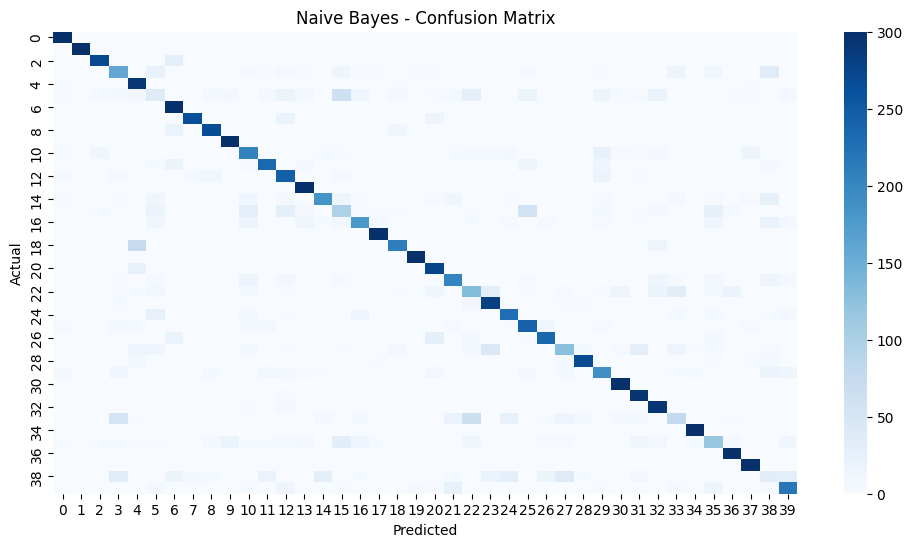

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluation Metrics (macro average)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='macro')
recall_nb = recall_score(y_test, y_pred_nb, average='macro')
f1_nb = f1_score(y_test, y_pred_nb, average='macro')

# Print key metrics
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")

# Confusion Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=False, fmt='d', cmap='Blues')
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM Accuracy: 0.8021
Precision: 0.7720
Recall: 0.8021
F1 Score: 0.7759


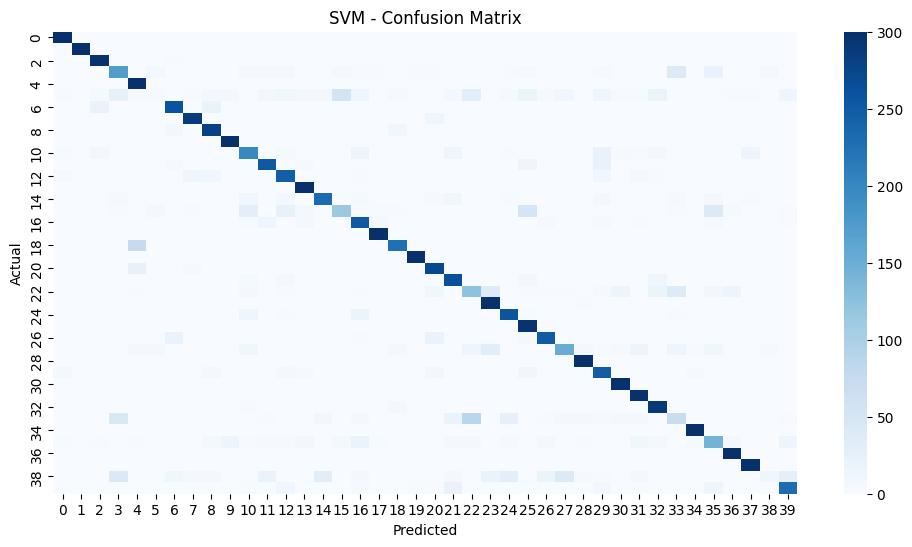

In [28]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM model
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluation Metrics (macro average)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
f1_svm = f1_score(y_test, y_pred_svm, average='macro')

# Print key metrics
print(f"SVM Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

# Confusion Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=False, fmt='d', cmap='Blues')
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Decision Tree Accuracy: 0.6996
Precision: 0.7047
Recall: 0.6996
F1 Score: 0.7015


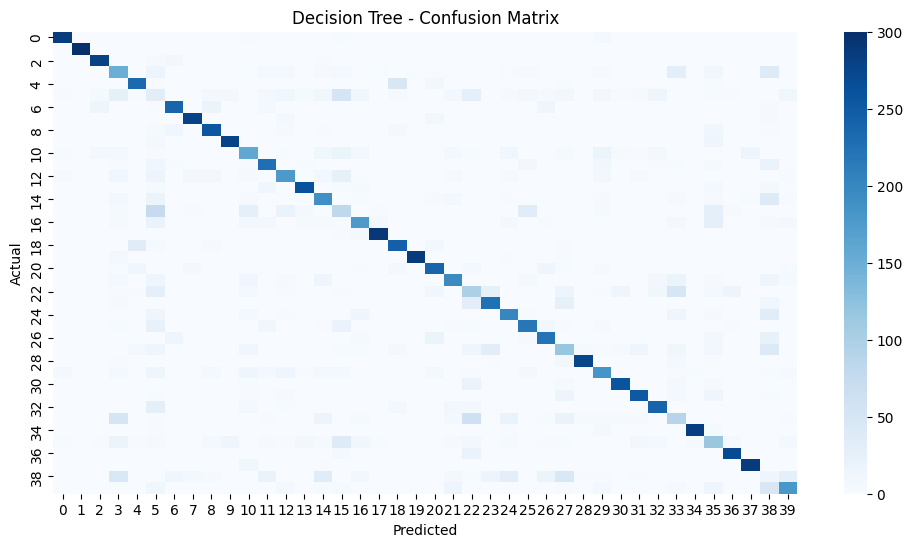

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)
y_pred_dt = dt_model.predict(X_test_tfidf)

# Evaluation Metrics (macro average)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='macro')
recall_dt = recall_score(y_test, y_pred_dt, average='macro')
f1_dt = f1_score(y_test, y_pred_dt, average='macro')

# Print key metrics
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")

# Confusion Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=False, fmt='d', cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random Forest Accuracy: 0.7453
Precision: 0.7284
Recall: 0.7453
F1 Score: 0.7357


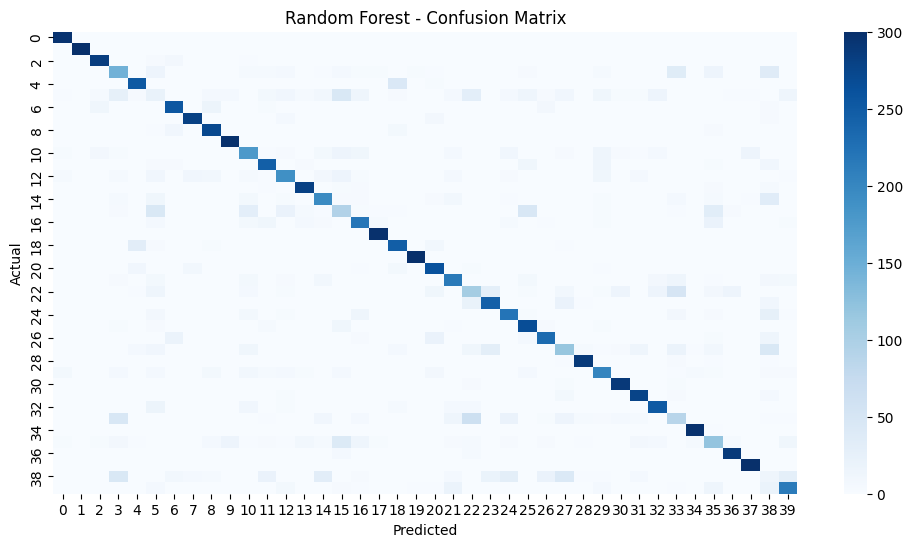

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluation Metrics (macro average)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

# Print key metrics
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

# Confusion Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=False, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

XGBoost Accuracy: 0.7648
Precision: 0.7382
Recall: 0.7647
F1 Score: 0.7490


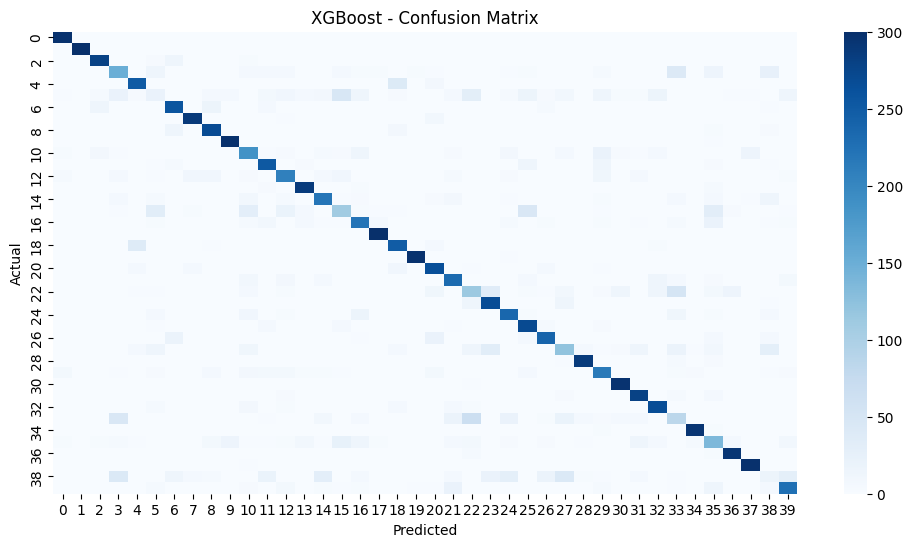

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import label_binarize

# Encode categorical labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_tfidf, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluation Metrics (macro average)
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
precision_xgb = precision_score(y_test_encoded, y_pred_xgb, average='macro')
recall_xgb = recall_score(y_test_encoded, y_pred_xgb, average='macro')
f1_xgb = f1_score(y_test_encoded, y_pred_xgb, average='macro')

# Print metrics
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

# Confusion Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_xgb), annot=False, fmt='d', cmap='Blues')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<Figure size 1200x800 with 0 Axes>

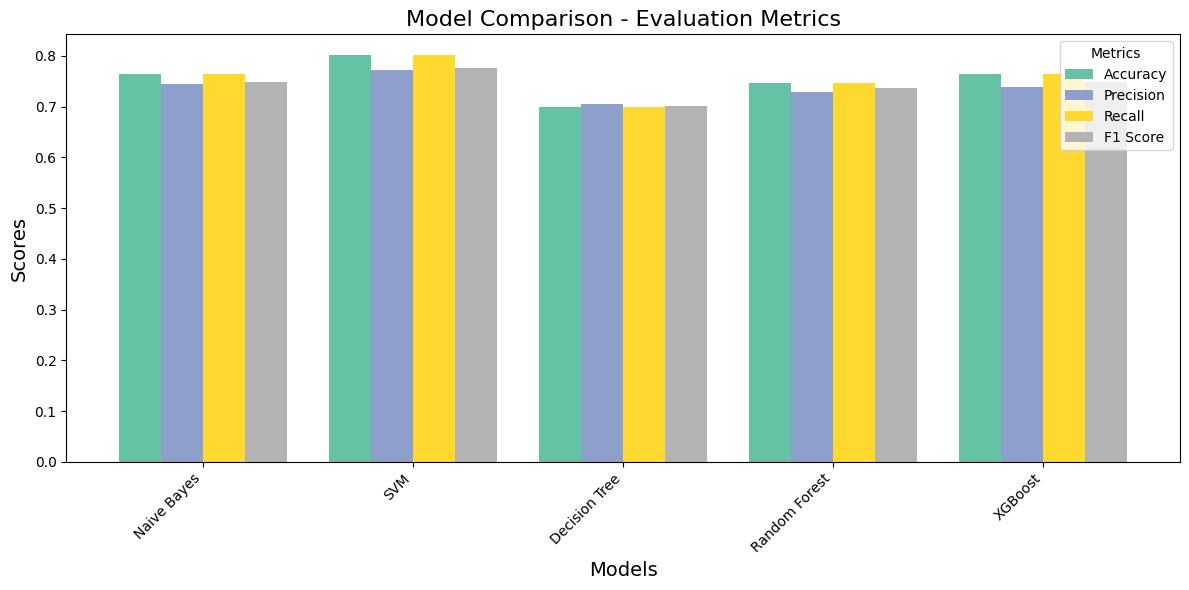

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collecting the evaluation metrics for each model
metrics_data = {
    'Model': ['Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_nb, accuracy_svm, accuracy_dt, accuracy_rf, accuracy_xgb],
    'Precision': [precision_nb, precision_svm, precision_dt, precision_rf, precision_xgb],
    'Recall': [recall_nb, recall_svm, recall_dt, recall_rf, recall_xgb],
    'F1 Score': [f1_nb, f1_svm, f1_dt, f1_rf, f1_xgb]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Set the figure size
plt.figure(figsize=(12, 8))

# Plotting the bar plot for all metrics
metrics_df.set_index('Model').plot(kind='bar', width=0.8, figsize=(12, 6), cmap='Set2')

# Set plot title and labels
plt.title('Model Comparison - Evaluation Metrics', fontsize=16)
plt.ylabel('Scores', fontsize=14)
plt.xlabel('Models', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend
plt.legend(title='Metrics')

# Display the plot
plt.tight_layout()
plt.show()